In [13]:
import os
import pandas as pd
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

def merge_stock_data(stock_dir):
    """Merge all bbo and trade files for a single stock and save the result."""
    bbo_dir = os.path.join(stock_dir, 'bbo')
    trade_dir = os.path.join(stock_dir, 'trade')
    
    # Ensure subdirectories exist
    if not os.path.exists(bbo_dir) or not os.path.exists(trade_dir):
        print(f"Skipping {stock_dir}: Missing 'bbo' or 'trade' subdirectories.")
        return None
    
    daily_dfs = []
    
    # Get sorted list of files in both directories
    bbo_files = sorted(os.listdir(bbo_dir))
    trade_files = sorted(os.listdir(trade_dir))
    
    # Match files by name (assuming they correspond, e.g., '1.csv', '2.csv')
    for bbo_file, trade_file in zip(bbo_files, trade_files):
        bbo_path = os.path.join(bbo_dir, bbo_file)
        trade_path = os.path.join(trade_dir, trade_file)
        
        if os.path.isfile(bbo_path) and os.path.isfile(trade_path):
            # Load the files
            bbo_df = pd.read_parquet(bbo_path)
            trade_df = pd.read_parquet(trade_path)
            
            # Merge on a common key (adjust the key column name as necessary)
            merged_df = pd.merge(bbo_df, trade_df, on='xltime', how='inner')  # Replace 'timestamp' if needed

            # Check if 'xltime' column exists and transform it to datetime
            if 'xltime' in merged_df.columns:
                merged_df['datetime'] = pd.to_datetime('1899-12-30') + pd.to_timedelta(merged_df['xltime'], unit='D')
            else:
                print("'xltime' column not found in the dataset.")

            aggregated_df = (
                merged_df.groupby(['datetime'])  # Grouping by 'datetime' or any key to identify duplicates
                .apply(lambda g: pd.Series({
                    'weighted_bid_price': (g['bid-price'] * g['bid-volume']).sum() / g['bid-volume'].sum(),
                    'total_bid_quantity': g['bid-volume'].sum(),
                    'max_bid_quantity': g['bid-volume'].max(),
                    'weighted_ask_price': (g['ask-price'] * g['ask-volume']).sum() / g['ask-volume'].sum(),
                    'total_ask_quantity': g['ask-volume'].sum(),
                    'max_ask_quantity': g['ask-volume'].max(),
                    'total_trade_volume': g['trade-volume'].sum(),


                }))
                .reset_index()
            )
            
            # Append the merged DataFrame to the list
            daily_dfs.append(aggregated_df)
        else:
            print(f"Skipping unmatched files: {bbo_file}, {trade_file}")
    
    # Concatenate all daily DataFrames into one for the stock
    if daily_dfs:
        stock_merged_df = pd.concat(daily_dfs, ignore_index=True)
        
        # Save the merged DataFrame in the stock's folder
        output_path = os.path.join(stock_dir, 'merged_data.csv')  # Save as CSV
        stock_merged_df.to_csv(output_path, index=False)
        print(f"Merged data saved for stock: {os.path.basename(stock_dir)}")
    else:
        print(f"No data to merge for stock: {os.path.basename(stock_dir)}")

def process_all_stocks(base_dir):
    """Process all stocks in the base directory."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            print(f"Processing stock: {stock}")
            merge_stock_data(stock_dir)
        else:
            print(f"Skipping non-directory item: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with the path to your stock directories
process_all_stocks(base_directory)


Skipping non-directory item: .DS_Store
Processing stock: A


KeyboardInterrupt: 

In [8]:
!pip install polars


     |████████████████████████████████| 33.0 MB 3.9 kB/s eta 0:00:011     |█████████████████▊              | 18.3 MB 14.0 MB/s eta 0:00:02MB 11.1 MB/s eta 0:00:01


In [18]:
import polars as pl
import os

def process_stock_with_polars(stock_dir):
    """Merge bbo and trade files for a single stock using Polars and perform aggregations."""
    bbo_dir = os.path.join(stock_dir, 'bbo')
    trade_dir = os.path.join(stock_dir, 'trade')

    # Ensure subdirectories exist
    if not os.path.exists(bbo_dir) or not os.path.exists(trade_dir):
        print(f"Skipping {stock_dir}: Missing 'bbo' or 'trade' subdirectories.")
        return

    # Get sorted list of Parquet files in both directories
    bbo_files = sorted([f for f in os.listdir(bbo_dir) if f.endswith(".parquet")])
    trade_files = sorted([f for f in os.listdir(trade_dir) if f.endswith(".parquet")])

    lazy_dfs = []

    for bbo_file, trade_file in zip(bbo_files, trade_files):
        bbo_path = os.path.join(bbo_dir, bbo_file)
        trade_path = os.path.join(trade_dir, trade_file)

        if os.path.isfile(bbo_path) and os.path.isfile(trade_path):
            # Load the Parquet files as Polars lazy DataFrames
            bbo_df = pl.read_parquet(bbo_path).lazy()
            trade_df = pl.read_parquet(trade_path).lazy()

            # Merge on xltime
            merged_df = bbo_df.join(trade_df, on="xltime", how="inner")



            # Ensure consistent types
            merged_df = merged_df.with_columns([
                pl.col("xltime").cast(pl.Float64),
                pl.col("bid-price").cast(pl.Float64).alias("bid-price"),
                pl.col("bid-volume").cast(pl.Float64),
                pl.col("ask-price").cast(pl.Float64),
                pl.col("ask-volume").cast(pl.Float64),
                pl.col("trade-price").cast(pl.Float64),
                pl.col("trade-volume").cast(pl.Float64)
            ])

            # Perform initial aggregation by `xltime`
            aggregated_df = (
                merged_df
                .group_by("xltime")
                .agg([
                    ((pl.col("bid-price") * pl.col("bid-volume")).sum() / pl.col("bid-volume").sum()).alias("weighted_bid_price"),
                    pl.col("bid-volume").sum().alias("total_bid_quantity"),
                    pl.col("bid-volume").max().alias("max_bid_quantity"),
                    ((pl.col("ask-price") * pl.col("ask-volume")).sum() / pl.col("ask-volume").sum()).alias("weighted_ask_price"),
                    pl.col("ask-volume").sum().alias("total_ask_quantity"),
                    pl.col("ask-volume").max().alias("max_ask_quantity"),
                    pl.col("trade-volume").sum().alias("total_trade_volume"),
                    ((pl.col("trade-price") * pl.col("trade-volume")).sum() / pl.col("trade-volume").sum()).alias("weighted_trade_price")
                ])
            )

            # Convert `xltime` to `datetime`
            excel_base_date = pl.datetime(1899, 12, 30)
            aggregated_df = aggregated_df.with_columns(
                (pl.col("xltime") * pl.duration(days=1) + excel_base_date).alias("datetime")
            )
            aggregated_df = aggregated_df.with_columns(pl.col("datetime").dt.convert_time_zone("America/New_York"))

            # Append the lazy DataFrame for processing
            lazy_dfs.append(aggregated_df)
        else:
            print(f"Skipping unmatched files: {bbo_file}, {trade_file}")

    if lazy_dfs:
        # Combine all daily lazy DataFrames into one
        all_data = pl.concat(lazy_dfs)

        # Collect and write to CSV
        final_df = all_data.collect()
        output_path = os.path.join(stock_dir, "merged_data.csv")
        final_df.write_csv(output_path)
        print(f"Merged data saved as CSV for stock: {os.path.basename(stock_dir)}")
    else:
        print(f"No data to merge for stock: {os.path.basename(stock_dir)}")



def process_all_stocks_with_polars(base_dir):
    """Process all stocks in the base directory using Polars."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            print(f"Processing stock: {stock}")
            process_stock_with_polars(stock_dir)
        else:
            print(f"Skipping non-directory item: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with the path to your stock directories
process_all_stocks_with_polars(base_directory)


Skipping non-directory item: .DS_Store
Processing stock: A
Merged data saved as CSV for stock: A
Processing stock: AA
Merged data saved as CSV for stock: AA
Processing stock: AAP
Merged data saved as CSV for stock: AAP
Processing stock: ABC
Merged data saved as CSV for stock: ABC
Processing stock: ABD
Merged data saved as CSV for stock: ABD
Processing stock: ABT
Merged data saved as CSV for stock: ABT
Processing stock: ACE
Merged data saved as CSV for stock: ACE
Processing stock: ACL
Merged data saved as CSV for stock: ACL
Processing stock: ACN
Merged data saved as CSV for stock: ACN
Processing stock: ADI
Merged data saved as CSV for stock: ADI
Processing stock: ADM
Merged data saved as CSV for stock: ADM
Processing stock: ADS
Merged data saved as CSV for stock: ADS
Processing stock: AEE
Merged data saved as CSV for stock: AEE
Processing stock: AEP
Merged data saved as CSV for stock: AEP
Processing stock: AES
Merged data saved as CSV for stock: AES
Processing stock: AFL
Merged data sav

In [22]:
import pandas as pd
merged_AA_data = pd.read_csv("/Users/othmaneio/Documents/financial_big_data/data/Aa/merged_data.csv")

In [23]:
merged_AA_data

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36.193999-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54.482000-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58.480000-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58.342000-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50.406000-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06.177000-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38.292999-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55.403000-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02.480000-04:00


In [21]:
import pandas as pd
import os

def sort_csv_by_datetime(base_dir):
    """Sort each CSV file in the stock directories by datetime."""
    for stock in sorted(os.listdir(base_dir)):
        stock_dir = os.path.join(base_dir, stock)
        if os.path.isdir(stock_dir):
            csv_path = os.path.join(stock_dir, "merged_data.csv")
            if os.path.exists(csv_path):
                try:
                    # Load the CSV file
                    df = pd.read_csv(csv_path)

                    # Ensure datetime column is in proper datetime format
                    df['datetime'] = pd.to_datetime(df['datetime'])

                    # Sort by datetime
                    df = df.sort_values(by='datetime')

                    # Save the sorted CSV back
                    df.to_csv(csv_path, index=False)
                    print(f"Sorted CSV saved for stock: {stock}")
                except Exception as e:
                    print(f"Error processing {csv_path}: {e}")
            else:
                print(f"No CSV found for stock: {stock}")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with your path
sort_csv_by_datetime(base_directory)


Sorted CSV saved for stock: A
Sorted CSV saved for stock: AA
Sorted CSV saved for stock: AAP
Sorted CSV saved for stock: ABC
Sorted CSV saved for stock: ABD
Sorted CSV saved for stock: ABT
Sorted CSV saved for stock: ACE
Sorted CSV saved for stock: ACL
Sorted CSV saved for stock: ACN
Sorted CSV saved for stock: ADI
Sorted CSV saved for stock: ADM
Sorted CSV saved for stock: ADS
Sorted CSV saved for stock: AEE
Sorted CSV saved for stock: AEP
Sorted CSV saved for stock: AES
Sorted CSV saved for stock: AFL
Sorted CSV saved for stock: AGN
Sorted CSV saved for stock: AHC
Sorted CSV saved for stock: AIG
Sorted CSV saved for stock: AIV
Sorted CSV saved for stock: AIZ
Sorted CSV saved for stock: AJG
Sorted CSV saved for stock: ALB
Sorted CSV saved for stock: ALK
Sorted CSV saved for stock: ALL
Sorted CSV saved for stock: AMB
Sorted CSV saved for stock: AMD
Sorted CSV saved for stock: AME
Sorted CSV saved for stock: AMP
Sorted CSV saved for stock: AMR
Sorted CSV saved for stock: AMT
Sorted CSV 

In [25]:
import os

# Define the parent directory where the folder resides
root_dir = "/Users/othmaneio/Documents/financial_big_data/data"

# Traverse through all subdirectories
for subdir, _, files in os.walk(root_dir):
    for file in files:
        if file == "merged_data.csv":  # Target only 'merged_data.csv'
            folder_name = os.path.basename(subdir)  # Get the parent folder name
            old_file_path = os.path.join(subdir, file)
            new_file_name = f"merged_data_{folder_name}.csv"  # Add folder name to the file
            new_file_path = os.path.join(subdir, new_file_name)

            # Rename the file
            try:
                os.rename(old_file_path, new_file_path)
                print(f"Renamed '{file}' to '{new_file_name}' in folder '{folder_name}'.")
            except Exception as e:
                print(f"Error renaming file in folder '{folder_name}': {e}")


Renamed 'merged_data.csv' to 'merged_data_AHC.csv' in folder 'AHC'.
Renamed 'merged_data.csv' to 'merged_data_AMR.csv' in folder 'AMR'.
Renamed 'merged_data.csv' to 'merged_data_CNP.csv' in folder 'CNP'.
Renamed 'merged_data.csv' to 'merged_data_CAT.csv' in folder 'CAT'.
Renamed 'merged_data.csv' to 'merged_data_AAP.csv' in folder 'AAP'.
Renamed 'merged_data.csv' to 'merged_data_AGN.csv' in folder 'AGN'.
Renamed 'merged_data.csv' to 'merged_data_ADS.csv' in folder 'ADS'.
Renamed 'merged_data.csv' to 'merged_data_CAH.csv' in folder 'CAH'.
Renamed 'merged_data.csv' to 'merged_data_CBG.csv' in folder 'CBG'.
Renamed 'merged_data.csv' to 'merged_data_ABD.csv' in folder 'ABD'.
Renamed 'merged_data.csv' to 'merged_data_BTM.csv' in folder 'BTM'.
Renamed 'merged_data.csv' to 'merged_data_ABC.csv' in folder 'ABC'.
Renamed 'merged_data.csv' to 'merged_data_EMN.csv' in folder 'EMN'.
Renamed 'merged_data.csv' to 'merged_data_AMT.csv' in folder 'AMT'.
Renamed 'merged_data.csv' to 'merged_data_ADI.cs

In [26]:
merged_AA_data= pd.read_csv('data/AA/merged_data_AA.csv')

In [27]:
merged_AA_data

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36.193999-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54.482000-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58.480000-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58.342000-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50.406000-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06.177000-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38.292999-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55.403000-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02.480000-04:00


In [39]:
# Ensure 'datetime' is properly converted to datetime format
df = merged_AA_data.copy()
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')



# Calculate delta time only for rows on the same day
df['date'] = df['datetime'].dt.date  # Extract the date
df['delta_time'] = df.groupby('date')['datetime'].diff().dt.total_seconds()

# Compute statistics for delta times within the same day
mean_delta_time = df['delta_time'].mean()
min_delta_time = df['delta_time'].min()
quantiles = df['delta_time'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
max_delta_time = df['delta_time'].max()

{
    "mean_delta_time": mean_delta_time,
    "min_delta_time": min_delta_time,
    "quantiles": quantiles,
    "max_delta_time": max_delta_time
}


{'mean_delta_time': 3.061276882358509,
 'min_delta_time': 0.000999,
 'quantiles': {0.01: 0.001,
  0.05: 0.005,
  0.25: 0.013001,
  0.5: 0.063999,
  0.75: 0.933,
  0.95: 8.6620002,
  0.99: 28.445439279999945},
 'max_delta_time': 11920.849}

In [34]:
# Ensure the 'datetime' column is properly converted to datetime64
df['datetime'] = pd.to_datetime(df['datetime'])

# Remove anything below seconds
df['datetime'] = df['datetime'].dt.floor('S')

# Display the updated DataFrame
df

,xltime,weighted_bid_price,total_bid_quantity,max_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,total_trade_volume,weighted_trade_price,datetime
0,40301.452502,13.380000,18.0,18.0,13.470000,5.0,5.0,500.0,13.47,2010-05-03 06:51:36-04:00
1,40301.500631,13.470000,24.0,5.0,13.500000,12.0,2.0,2000.0,13.47,2010-05-03 08:00:54-04:00
2,40301.504844,13.470000,348.0,58.0,13.500000,141.0,25.0,2000.0,13.50,2010-05-03 08:06:58-04:00
3,40301.506231,13.470000,23.0,23.0,13.500000,5.0,5.0,1300.0,13.50,2010-05-03 08:08:58-04:00
4,40301.513778,13.499899,99.0,49.0,13.500000,17.0,6.0,300.0,13.50,2010-05-03 08:19:50-04:00
...,...,...,...,...,...,...,...,...,...,...
327781,40326.929933,11.650000,40.0,20.0,11.720000,42.0,21.0,550.0,11.66,2010-05-28 18:19:06-04:00
327782,40326.933082,11.636667,6.0,2.0,11.700000,8.0,2.0,1000.0,11.64,2010-05-28 18:23:38-04:00
327783,40326.949947,11.600000,2.0,2.0,11.700000,3.0,3.0,100.0,11.63,2010-05-28 18:47:55-04:00
327784,40326.990306,11.660000,15.0,9.0,11.700000,6.0,3.0,600.0,11.66,2010-05-28 19:46:02-04:00


In [2]:
df = merged_AA_data.copy()

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
# Ensure the `datetime` column is in minute-level precision
df['minute'] = df['datetime'].dt.floor('T')

# Perform aggregation grouped by `minute` with proper weighted calculations
aggregated_df = (
    df.groupby("minute")
    .apply(
        lambda group: pd.Series({
            "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
            "max_bid_quantity": group["max_bid_quantity"].max(),
            "total_bid_quantity": group["total_bid_quantity"].sum(),
            "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
            "total_ask_quantity": group["total_ask_quantity"].sum(),
            "max_ask_quantity": group["max_ask_quantity"].max(),
            "weighted_trade_price": (group["weighted_trade_price"] * group["total_trade_volume"]).sum() / group["total_trade_volume"].sum(),
            "total_trade_volume": group["total_trade_volume"].sum(),
        })
    )
    .reset_index()
)

NameError: name 'merged_AA_data' is not defined

In [88]:
df = aggregated_df.copy()
df

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume
0,2010-05-03 06:51:00-04:00,13.380000,18.0,18.0,13.470000,5.0,5.0,13.47,500.0
1,2010-05-03 08:00:00-04:00,13.470000,5.0,24.0,13.500000,12.0,2.0,13.47,2000.0
2,2010-05-03 08:06:00-04:00,13.470000,58.0,348.0,13.500000,141.0,25.0,13.50,2000.0
3,2010-05-03 08:08:00-04:00,13.470000,23.0,23.0,13.500000,5.0,5.0,13.50,1300.0
4,2010-05-03 08:19:00-04:00,13.499899,49.0,99.0,13.500000,17.0,6.0,13.50,300.0
...,...,...,...,...,...,...,...,...,...
9759,2010-05-28 18:19:00-04:00,11.650000,20.0,40.0,11.720000,42.0,21.0,11.66,550.0
9760,2010-05-28 18:23:00-04:00,11.636667,2.0,6.0,11.700000,8.0,2.0,11.64,1000.0
9761,2010-05-28 18:47:00-04:00,11.600000,2.0,2.0,11.700000,3.0,3.0,11.63,100.0
9762,2010-05-28 19:46:00-04:00,11.660000,9.0,15.0,11.700000,6.0,3.0,11.66,600.0


In [92]:

# Calculate delta time only for rows on the same day

df['date'] = df['minute'].dt.date  # Extract the date
df['delta_time'] = df.groupby('date')['minute'].diff().dt.total_seconds()/60



# Compute statistics for delta times within the same day
mean_delta_time = df['delta_time'].mean()
min_delta_time = df['delta_time'].min()
quantiles = df['delta_time'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
max_delta_time = df['delta_time'].max()

{
    "mean_delta_time": mean_delta_time,
    "min_delta_time": min_delta_time,
    "quantiles": quantiles,
    "max_delta_time": max_delta_time
}

{'mean_delta_time': 1.7152093596059113,
 'min_delta_time': 1.0,
 'quantiles': {0.01: 1.0,
  0.05: 1.0,
  0.25: 1.0,
  0.5: 1.0,
  0.75: 1.0,
  0.95: 4.0,
  0.99: 17.0},
 'max_delta_time': 198.0}

In [93]:
import numpy as np

# Compute log returns normalized by the time interval

merged_AA_data = pd.read_csv()

df = merged_AA_data.copy('/Users/othmaneio/Documents/financial_big_data/data/AA/merged_data_AA.csv')

df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

df['minute'] = df['datetime'].dt.floor('T')

# Perform aggregation grouped by `minute` with proper weighted calculations
aggregated_df = (
    df.groupby("minute")
    .apply(
        lambda group: pd.Series({
            "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
            "max_bid_quantity": group["max_bid_quantity"].max(),
            "total_bid_quantity": group["total_bid_quantity"].sum(),
            "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
            "total_ask_quantity": group["total_ask_quantity"].sum(),
            "max_ask_quantity": group["max_ask_quantity"].max(),
            "weighted_trade_price": (group["weighted_trade_price"] * group["total_trade_volume"]).sum() / group["total_trade_volume"].sum(),
            "total_trade_volume": group["total_trade_volume"].sum(),
        })
    )
    .reset_index()
)

df = aggregated_df

df['date'] = df['minute'].dt.date  # Extract the date
df['delta_time'] = df.groupby('date')['minute'].diff().dt.total_seconds()/60

df['return'] = (df['weighted_trade_price'] - df['weighted_trade_price'].shift(1)) / df['weighted_trade_price'].shift(1)

# Normalize returns by delta time (time interval between ticks) within the same day
df['normalized_return'] = df['return'] / df['delta_time']

# Ensure normalization is limited to rows with valid delta_time and log_return
df['normalized_return'] = df['normalized_return'].where(df['delta_time'] > 0, np.nan)

# Compute daily normalization factor to scale returns to one day
# Assuming 'delta_time' is in seconds, scale returns to a 24-hour interval (86400 seconds)
#df['daily_normalized_return'] = df['normalized_return'] * 480  # Seconds in a day

# Drop NaN values for clean results
#df.dropna(subset=['daily_normalized_return'], inplace=True)

# Display relevant columns
#result = df[['minute', 'delta_time', 'return', 'normalized_return', 'daily_normalized_return']]



In [97]:
# Compute log returns normalized by the time interval
df['return'] = (df['weighted_trade_price'] - df['weighted_trade_price'].shift(1)) / df['weighted_trade_price'].shift(1)

# Normalize returns by delta time (time interval between ticks) within the same day
df['normalized_return'] = df['return'] / df['delta_time']

# Ensure normalization is limited to rows with valid delta_time and log_return
df['normalized_return'] = df['normalized_return'].where(df['delta_time'] > 0, np.nan)

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return
0,2010-05-03 06:51:00-04:00,13.380000,18.0,18.0,13.470000,5.0,5.0,13.47,500.0,2010-05-03,NaN,NaN,NaN
1,2010-05-03 08:00:00-04:00,13.470000,5.0,24.0,13.500000,12.0,2.0,13.47,2000.0,2010-05-03,69.0,0.000000,0.000000
2,2010-05-03 08:06:00-04:00,13.470000,58.0,348.0,13.500000,141.0,25.0,13.50,2000.0,2010-05-03,6.0,0.002227,0.000371
3,2010-05-03 08:08:00-04:00,13.470000,23.0,23.0,13.500000,5.0,5.0,13.50,1300.0,2010-05-03,2.0,0.000000,0.000000
4,2010-05-03 08:19:00-04:00,13.499899,49.0,99.0,13.500000,17.0,6.0,13.50,300.0,2010-05-03,11.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9759,2010-05-28 18:19:00-04:00,11.650000,20.0,40.0,11.720000,42.0,21.0,11.66,550.0,2010-05-28,9.0,0.000000,0.000000
9760,2010-05-28 18:23:00-04:00,11.636667,2.0,6.0,11.700000,8.0,2.0,11.64,1000.0,2010-05-28,4.0,-0.001715,-0.000429
9761,2010-05-28 18:47:00-04:00,11.600000,2.0,2.0,11.700000,3.0,3.0,11.63,100.0,2010-05-28,24.0,-0.000859,-0.000036
9762,2010-05-28 19:46:00-04:00,11.660000,9.0,15.0,11.700000,6.0,3.0,11.66,600.0,2010-05-28,59.0,0.002580,0.000044


In [94]:
# Compute statistics for delta times within the same day
mean_daily_normalized_return = df['normalized_return'].mean()
min_daily_normalized_return = df['normalized_return'].min()
quantiles = df['normalized_return'].quantile([0.01,0.05,0.25, 0.5, 0.75, 0.95, 0.99]).to_dict()
#max_daily_normalized_return = df['daily_normalized_return'].max()

{
    "mean_daily_normalized_return": mean_daily_normalized_return,
    "min_daily_normalized_return": min_daily_normalized_return,
    "quantiles": quantiles,
    #"max_daily_normalized_return": max_daily_normalized_return
}

{'mean_daily_normalized_return': -1.6988850462960015e-05,
 'min_daily_normalized_return': -0.014133496040299544,
 'quantiles': {0.01: -0.0035346361412054933,
  0.05: -0.0018317724531665934,
  0.25: -0.0006110603577194742,
  0.5: 0.0,
  0.75: 0.0005482257425310205,
  0.95: 0.001839343068808909,
  0.99: 0.0034927313474027734}}

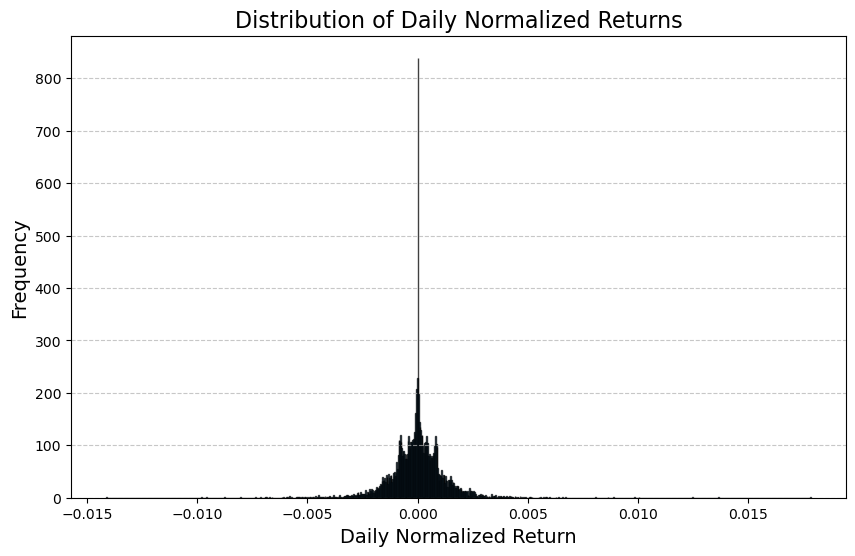

In [9]:
import matplotlib.pyplot as plt


df = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/data/AA/processed_data_AA.csv')
# Plot the distribution of daily normalized returns
plt.figure(figsize=(10, 6))
plt.hist(df['normalized_return'], bins=1000, alpha=0.75, edgecolor='black')
plt.title('Distribution of Daily Normalized Returns', fontsize=16)
plt.xlabel('Daily Normalized Return', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
#perform ks test for df['normalized_return']
from scipy.stats import kstest
ks_statistic, ks_p_value = kstest(df['normalized_return'].dropna(), 'norm')
    
{
        "ks_statistic": ks_statistic,
        "ks_p_value": ks_p_value
}

{'ks_statistic': 0.49655524211754837, 'ks_p_value': 0.0}

In [10]:
df.head()

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return
0,2010-05-03 06:51:00-04:00,13.380000,18.0,18.0,13.47,5.0,5.0,13.47,500.0,2010-05-03,NaN,NaN,NaN
1,2010-05-03 08:00:00-04:00,13.470000,5.0,24.0,13.50,12.0,2.0,13.47,2000.0,2010-05-03,69.0,0.000000,0.000000
2,2010-05-03 08:06:00-04:00,13.470000,58.0,348.0,13.50,141.0,25.0,13.50,2000.0,2010-05-03,6.0,0.002227,0.000371
3,2010-05-03 08:08:00-04:00,13.470000,23.0,23.0,13.50,5.0,5.0,13.50,1300.0,2010-05-03,2.0,0.000000,0.000000
4,2010-05-03 08:19:00-04:00,13.499899,49.0,99.0,13.50,17.0,6.0,13.50,300.0,2010-05-03,11.0,0.000000,0.000000


In [11]:
#distribution of the hours in the df
# Convert the 'minute' column to datetime
df["minute"] = pd.to_datetime(df["minute"])

# Define the time intervals (e.g., every 30 minutes)
df["time_interval"] = pd.cut(
    df["minute"].dt.hour * 60 + df["minute"].dt.minute,
    bins=range(0, 1441, 30),
    labels=[f"{h:02}:{m:02}-{h2:02}:{m2:02}" for h in range(24) for m, h2, m2 in [(0, h, 30), (30, h+1, 0)]],
    right=False
)

# Count observations per interval
interval_counts = df["time_interval"].value_counts().sort_index()


In [12]:
interval_counts

time_interval
00:00-00:30      0
00:30-01:00      0
01:00-01:30      0
01:30-02:00      0
02:00-02:30      0
02:30-03:00      0
03:00-03:30      0
03:30-04:00      0
04:00-04:30      4
04:30-05:00     19
05:00-05:30     10
05:30-06:00     16
06:00-06:30     14
06:30-07:00     25
07:00-07:30     67
07:30-08:00     95
08:00-08:30    335
08:30-09:00    336
09:00-09:30    357
09:30-10:00    600
10:00-10:30    600
10:30-11:00    598
11:00-11:30    600
11:30-12:00    599
12:00-12:30    598
12:30-13:00    598
13:00-13:30    591
13:30-14:00    596
14:00-14:30    598
14:30-15:00    598
15:00-15:30    600
15:30-16:00    600
16:00-16:30    159
16:30-17:00    112
17:00-17:30     54
17:30-18:00     92
18:00-18:30     81
18:30-19:00     79
19:00-19:30     55
19:30-20:00     78
20:00-20:30      0
20:30-21:00      0
21:00-21:30      0
21:30-22:00      0
22:00-22:30      0
22:30-23:00      0
23:00-23:30      0
23:30-24:00      0
Name: count, dtype: int64

In [1]:
import os
import pandas as pd
import numpy as np

def process_all_companies(base_dir):
    """Process all company data: aggregate by minute, calculate normalized returns."""
    for company in sorted(os.listdir(base_dir)):
        company_dir = os.path.join(base_dir, company)
        csv_path = os.path.join(company_dir, f"merged_data_{company}.csv")
        
        if os.path.isdir(company_dir) and os.path.exists(csv_path):
            print(f"Processing data for company: {company}")
            
            try:
                # Load the CSV file
                df = pd.read_csv(csv_path)

                # Ensure datetime column is properly formatted
                df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

                # Aggregate data by minute
                df['minute'] = df['datetime'].dt.floor('T')
                aggregated_df = (
                    df.groupby("minute")
                    .apply(
                        lambda group: pd.Series({
                            "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
                            "max_bid_quantity": group["max_bid_quantity"].max(),
                            "total_bid_quantity": group["total_bid_quantity"].sum(),
                            "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
                            "total_ask_quantity": group["total_ask_quantity"].sum(),
                            "max_ask_quantity": group["max_ask_quantity"].max(),
                            "weighted_trade_price": (group["weighted_trade_price"] * group["total_trade_volume"]).sum() / group["total_trade_volume"].sum(),
                            "total_trade_volume": group["total_trade_volume"].sum(),
                        })
                    )
                    .reset_index()
                )

                # Add columns for time differences and returns
                aggregated_df['date'] = aggregated_df['minute'].dt.date
                aggregated_df['delta_time'] = aggregated_df.groupby('date')['minute'].diff().dt.total_seconds() / 60
                aggregated_df['return'] = (
                    (aggregated_df['weighted_trade_price'] - aggregated_df['weighted_trade_price'].shift(1))
                    / aggregated_df['weighted_trade_price'].shift(1)
                )

                # Normalize returns by delta time
                aggregated_df['normalized_return'] = aggregated_df['return'] / aggregated_df['delta_time']
                aggregated_df['normalized_return'] = aggregated_df['normalized_return'].where(
                    aggregated_df['delta_time'] > 0, np.nan
                )

                # Save the processed DataFrame back
                output_path = os.path.join(company_dir, f"processed_data_{company}.csv")
                aggregated_df.to_csv(output_path, index=False)
                print(f"Processed data saved for company: {company}")
            except Exception as e:
                print(f"Error processing data for company {company}: {e}")
        else:
            print(f"Skipping {company}: No valid data found.")

# Example usage
base_directory = "/Users/othmaneio/Documents/financial_big_data/data"  # Replace with your base directory
process_all_companies(base_directory)


/Users/othmaneio/opt/miniconda3/envs/adaexam/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Skipping .DS_Store: No valid data found.
Processing data for company: A


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: A
Processing data for company: AA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AA
Processing data for company: AAP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AAP
Processing data for company: ABC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ABC
Processing data for company: ABD


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ABD
Processing data for company: ABT


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ABT
Processing data for company: ACE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ACE
Processing data for company: ACL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ACL
Processing data for company: ACN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ACN
Processing data for company: ADI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ADI
Processing data for company: ADM


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ADM
Processing data for company: ADS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ADS
Processing data for company: AEE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AEE
Processing data for company: AEP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AEP
Processing data for company: AES


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AES
Processing data for company: AFL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AFL
Processing data for company: AGN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AGN
Processing data for company: AHC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AHC
Processing data for company: AIG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AIG
Processing data for company: AIV


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AIV
Processing data for company: AIZ


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AIZ
Processing data for company: AJG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AJG
Processing data for company: ALB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ALB
Processing data for company: ALK


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ALK
Processing data for company: ALL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ALL
Processing data for company: AMB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AMB
Processing data for company: AMD


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AMD
Processing data for company: AME


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AME
Processing data for company: AMP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AMP
Processing data for company: AMR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AMR
Processing data for company: AMT


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AMT
Processing data for company: AON


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AON
Processing data for company: AOS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AOS
Processing data for company: APA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: APA
Processing data for company: APD


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: APD
Processing data for company: APH


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: APH
Processing data for company: ARE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ARE
Processing data for company: ATO


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ATO
Processing data for company: AVB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AVB
Processing data for company: AVY


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AVY
Processing data for company: AWK


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AWK
Processing data for company: AXP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AXP
Processing data for company: AZO


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: AZO
Processing data for company: BA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BA
Processing data for company: BAC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping c

Processed data saved for company: BAC
Processing data for company: BAX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BAX
Processing data for company: BBY


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BBY
Processing data for company: BDX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BDX
Processing data for company: BEN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BEN
Processing data for company: BFO
Processed data saved for company: BFO
Processing data for company: BH


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning

Processed data saved for company: BH
Processing data for company: BK


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BK
Processing data for company: BKR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BKR
Processing data for company: BLK


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BLK
Processing data for company: BLL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BLL
Processing data for company: BMY


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BMY
Processing data for company: BR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BR
Processing data for company: BSX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BSX
Processing data for company: BTM


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BTM
Processing data for company: BWA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BWA
Processing data for company: BXP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: BXP
Processing data for company: C


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: C
Processing data for company: CAG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CAG
Processing data for company: CAH


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CAH
Processing data for company: CAT


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CAT
Processing data for company: CB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CB
Processing data for company: CBG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CBG
Processing data for company: CCI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CCI
Processing data for company: CCL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping c

Processed data saved for company: CCL
Processing data for company: CE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CE
Processing data for company: CF


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CF
Processing data for company: CHD


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CHD
Processing data for company: CHL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')


Processed data saved for company: CHL
Processing data for company: CHP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CHP
Processing data for company: CI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CI
Processing data for company: CL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CL
Processing data for company: CLX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CLX
Processing data for company: CMA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CMA
Processing data for company: CMG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CMG
Processing data for company: CMI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CMI
Processing data for company: CMS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning

Processed data saved for company: CMS
Processing data for company: CMT
Processed data saved for company: CMT
Processing data for company: CNC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CNC
Processing data for company: CNP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CNP
Processing data for company: COF


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COF
Processing data for company: COG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COG
Processing data for company: COH


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COH
Processing data for company: COL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COL
Processing data for company: COO


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COO
Processing data for company: COP


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: COP
Processing data for company: CPB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CPB
Processing data for company: CPC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CPC
Processing data for company: CRM


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CRM
Processing data for company: CSC


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CSC
Processing data for company: CSX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CSX
Processing data for company: CTL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CTL
Processing data for company: CVS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CVS
Processing data for company: CVX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CVX
Processing data for company: CXO


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: CXO
Processing data for company: D


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: D
Processing data for company: DAL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DAL
Processing data for company: DD


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DD
Processing data for company: DE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DE
Processing data for company: DFS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DFS
Processing data for company: DG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DG
Processing data for company: DGX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DGX
Processing data for company: DHI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DHI
Processing data for company: DHR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DHR
Processing data for company: DIS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DIS
Processing data for company: DLR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DLR
Processing data for company: DNB


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DNB
Processing data for company: DOV


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DOV
Processing data for company: DOW


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DOW
Processing data for company: DRE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DRE
Processing data for company: DRI


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DRI
Processing data for company: DTE


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DTE
Processing data for company: DUK


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DUK
Processing data for company: DVA


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DVA
Processing data for company: DVN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:27: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_bid_price": (group["weighted_bid_price"] * group["total_bid_quantity"]).sum() / group["total_bid_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: DVN
Processing data for company: E


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: E
Processing data for company: ECL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ECL
Processing data for company: ED


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ED
Processing data for company: EFX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EFX
Processing data for company: EIX


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EIX
Processing data for company: EL


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EL
Processing data for company: EMN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EMN
Processing data for company: EMR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EMR
Processing data for company: EOG


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EOG
Processing data for company: EQR


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: EQR
Processing data for company: ES


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ES
Processing data for company: ESS


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ESS
Processing data for company: ESV


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


Processed data saved for company: ESV
Processing data for company: ETN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['minute'] = df['datetime'].dt.floor('T')
/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:30: RuntimeWarning: invalid value encountered in scalar divide
  "weighted_ask_price": (group["weighted_ask_price"] * group["total_ask_quantity"]).sum() / group["total_ask_quantity"].sum(),


Processed data saved for company: ETN


/var/folders/m4/7y6r9d5x1f9g7xkd8133tc2r0000gn/T/ipykernel_6567/1531866637.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby("minute")


In [23]:
pAdf = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/data/processed_data/processed_data_A.csv')

In [26]:
len(pAdf.columns)

13

In [22]:
import os
import pandas as pd

# Path to the folder containing stock data files
folder_path = '/Users/othmaneio/Documents/financial_big_data/data/processed_data'

# Define the start and end time
start_time = pd.to_datetime('09:30:00').time()
end_time = pd.to_datetime('16:00:00').time()

filtered_dataframes = {}

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):  # Assuming files are in CSV format
        # Construct the file path
        file_path = os.path.join(folder_path, file_name)

        # Load the stock data
        stock_df = pd.read_csv(file_path)

        # Convert the 'minute' column to datetime
        stock_df['minute'] = pd.to_datetime(stock_df['minute'])

        # Filter rows between the specified times
        df_filtered = stock_df[
            (stock_df['minute'].dt.time >= start_time) &
            (stock_df['minute'].dt.time <= end_time)&
            (stock_df['weighted_ask_price'] > stock_df['weighted_bid_price']) &
            (stock_df['weighted_ask_price'] > 0) &
            (stock_df['weighted_bid_price'] > 0)
        ]

        # Store the filtered dataframe in a dictionary
        filtered_dataframes[file_name] = df_filtered

        # Save the filtered data back to a new file
        output_file_name = f"{file_name}"
        output_path = os.path.join(folder_path, output_file_name)
        df_filtered.to_csv(output_path, index=False)

# Display a summary message
print(f"Processed and saved filtered data for {len(filtered_dataframes)} files.")


Processed and saved filtered data for 133 files.


In [14]:
import shutil 
def create_processed_data_dir(base_dir):
    main_directory = base_dir

    # Define the target directory for processed data files
    target_directory = os.path.join(main_directory, 'processed_data')

    # Create the target directory if it doesn't exist
    os.makedirs(target_directory, exist_ok=True)

    # Loop through the subdirectories
    for subdir in os.listdir(main_directory):
        subdir_path = os.path.join(main_directory, subdir)
        if os.path.isdir(subdir_path):  # Check if it's a directory
            # Construct the expected file name
            processed_file_name = f"processed_data_{subdir}.csv"
            processed_file_path = os.path.join(subdir_path, processed_file_name)
        
            # Check if the processed data file exists
            if os.path.exists(processed_file_path):
                # Move the file to the target directory
                shutil.copy(processed_file_path, os.path.join(target_directory, processed_file_name))
                print(f"Moved: {processed_file_path} -> {target_directory}")
            else:
                print(f"File not found: {processed_file_path}")


create_processed_data_dir('/Users/othmaneio/Documents/financial_big_data/data')

Moved: /Users/othmaneio/Documents/financial_big_data/data/AHC/processed_data_AHC.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/AMR/processed_data_AMR.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/CNP/processed_data_CNP.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/CAT/processed_data_CAT.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/AAP/processed_data_AAP.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/AGN/processed_data_AGN.csv -> /Users/othmaneio/Documents/financial_big_data/data/processed_data
Moved: /Users/othmaneio/Documents/financial_big_data/data/ADS/processed_data

In [27]:
import os
import pandas as pd

# Path to the folder containing stock data files
folder_path = '/Users/othmaneio/Documents/financial_big_data/data/processed_data'

# List to store individual DataFrames
all_dfs = []

# Iterate through each file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith(".csv"):
        # Load the stock data
        file_path = os.path.join(folder_path, file_name)
        df = pd.read_csv(file_path)
        
        # Extract stock name from the file name
        stock_name = file_name.split("_")[-1].replace(".csv", "")
        
        # Add a column identifying the stock
        df['stock'] = stock_name
        
        # Append to the list
        all_dfs.append(df)

# Concatenate all DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)

# Save the combined DataFrame to disk
combined_df.to_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv', index=False)


In [28]:
df = pd.read_csv('/Users/othmaneio/Documents/financial_big_data/combined_stock_data.csv')

In [32]:
df[df['stock'] == 'DLR'].head()

,minute,weighted_bid_price,max_bid_quantity,total_bid_quantity,weighted_ask_price,total_ask_quantity,max_ask_quantity,weighted_trade_price,total_trade_volume,date,delta_time,return,normalized_return,stock
0,2010-05-03 09:30:00-04:00,58.960000,6.0,35.0,59.065455,11.0,2.0,59.030000,1200.0,2010-05-03,NaN,NaN,NaN,DLR
1,2010-05-03 09:32:00-04:00,59.028846,5.0,26.0,59.143333,12.0,2.0,59.103284,1218.0,2010-05-03,2.0,0.001241,0.000621,DLR
2,2010-05-03 09:33:00-04:00,59.304444,4.0,9.0,59.555000,10.0,3.0,59.518000,500.0,2010-05-03,1.0,0.007017,0.007017,DLR
3,2010-05-03 09:34:00-04:00,59.560000,1.0,2.0,59.660000,4.0,2.0,59.560000,400.0,2010-05-03,1.0,0.000706,0.000706,DLR
4,2010-05-03 09:35:00-04:00,59.570000,1.0,1.0,59.710000,5.0,5.0,59.680000,100.0,2010-05-03,1.0,0.002015,0.002015,DLR
